In [157]:
import numpy as np
import pandas as pd
from pandas import Series
from pandas import DataFrame

import os
from os import environ
import requests
import io

import math

import matplotlib.pyplot as plt

In [158]:
Data=pd.read_csv('SQLsnippet_"CPH".csv')
Data.columns=[x.replace(' ','') for x in Data.columns]

In [159]:
Data.columns

Index(['id', 'observation_date', 'observation_time', 'pos', 'origin',
       'destination', 'is_one_way', 'outbound_travel_stop_over',
       'inbound_travel_stop_over', 'carrier', 'outbound_flight_no',
       'inbound_flight_no', 'outbound_departure_date',
       'outbound_departure_time', 'outbound_arrival_date',
       'outbound_arrival_time', 'inbound_departure_date',
       'inbound_departure_time', 'inbound_arrival_date',
       'inbound_arrival_time', 'outbound_fare_basis', 'inbound_fare_basis',
       'outbound_booking_class', 'inbound_booking_class', 'price_exc',
       'price_inc', 'tax', 'currency', 'source', 'price_outbound',
       'price_inbound', 'is_tax_inc_outin', 'search_class',
       'outbound_fare_family', 'inbound_fare_family', 'outbound_seats',
       'inbound_seats', 'min_stay', 'outbound_flight_duration',
       'inbound_flight_duration'],
      dtype='object')

In [160]:
Data['min_stay']=Data[['is_one_way','min_stay']].apply(lambda x: -1 if x[0]==1 else x[1],axis=1)
minstay_map=DataFrame([[x for x in range(-1,11)],['one way','0 days','1 day']+[str(x)+' days' for x in range(2,11)]],index=['min_stay','min_stay_new']).transpose()
Data=Data.merge(minstay_map,on='min_stay')
Data['min_stay']=Data['min_stay_new']
Data=Data[[x for x in Data.columns if x!='min_stay_new']]

In [161]:
Data=Data[['carrier','observation_date','origin','destination','outbound_departure_date','min_stay',
'outbound_departure_time','inbound_departure_time','outbound_seats','inbound_seats','price_outbound','price_inbound','price_exc']]

Data=Data.loc[Data['observation_date']==sorted(Data['observation_date'].unique())[len(Data['observation_date'].unique())-1],:]
Data['outbound_departure_date']=pd.to_datetime(Data['outbound_departure_date'])

In [162]:
Data

,carrier,observation_date,origin,destination,outbound_departure_date,min_stay,outbound_departure_time,inbound_departure_time,outbound_seats,inbound_seats,price_outbound,price_inbound,price_exc
57609,LG,2019-06-20,CPH,LUX,2019-07-02,2 days,08:35,12:40,9.0,9.0,135.79,145.97,282.00
57610,LG,2019-06-20,CPH,LUX,2019-07-02,2 days,08:35,17:55,9.0,6.0,135.79,145.97,282.00
57611,LG,2019-06-20,CPH,LUX,2019-07-02,2 days,15:10,12:40,9.0,9.0,145.97,145.97,292.00
57612,LG,2019-06-20,CPH,LUX,2019-07-02,2 days,15:10,17:55,9.0,6.0,145.97,145.97,292.00
57613,LG,2019-06-20,CPH,LUX,2019-07-02,2 days,20:30,12:40,9.0,9.0,165.93,145.97,312.00
57614,LG,2019-06-20,CPH,LUX,2019-07-02,2 days,20:30,17:55,9.0,6.0,165.93,145.97,312.00
57615,LG,2019-06-20,LUX,CPH,2019-10-21,2 days,06:10,20:30,8.0,9.0,61.50,61.50,123.00
57616,LG,2019-06-20,LUX,CPH,2019-10-21,2 days,12:40,20:30,9.0,9.0,61.50,61.50,123.00
57617,LG,2019-06-20,LUX,CPH,2019-10-21,2 days,17:55,08:35,9.0,9.0,61.50,61.50,123.00
57618,LG,2019-06-20,LUX,CPH,2019-10-21,2 days,17:55,15:10,9.0,9.0,61.50,61.50,123.00


In [115]:
Data_lg_oneway=Data.loc[(Data['carrier']=='LG')&(Data['min_stay']=='one way'),:]
Data_lg_twoway=Data.loc[(Data['carrier']=='LG')&(Data['min_stay']!='one way'),:]
Data_comp_oneway=Data.loc[(Data['carrier']!='LG')&(Data['min_stay']=='one way'),:]
Data_comp_twoway=Data.loc[(Data['carrier']!='LG')&(Data['min_stay']!='one way'),:]

In [117]:
Data_lg_oneway=Data_lg.groupby(['carrier','observation_date','origin','destination','outbound_departure_date','min_stay',
'outbound_departure_time'])['price_exc'].mean().reset_index()

In [125]:
sorted(Data_comp_oneway.loc[Data_comp_oneway['outbound_departure_time']=='06:10','outbound_departure_date'].unique())

[numpy.datetime64('2019-06-20T00:00:00.000000000'),
 numpy.datetime64('2019-06-21T00:00:00.000000000'),
 numpy.datetime64('2019-06-22T00:00:00.000000000'),
 numpy.datetime64('2019-06-23T00:00:00.000000000'),
 numpy.datetime64('2019-06-24T00:00:00.000000000'),
 numpy.datetime64('2019-06-25T00:00:00.000000000'),
 numpy.datetime64('2019-06-26T00:00:00.000000000'),
 numpy.datetime64('2019-06-27T00:00:00.000000000'),
 numpy.datetime64('2019-06-28T00:00:00.000000000'),
 numpy.datetime64('2019-06-29T00:00:00.000000000'),
 numpy.datetime64('2019-06-30T00:00:00.000000000'),
 numpy.datetime64('2019-07-01T00:00:00.000000000'),
 numpy.datetime64('2019-07-02T00:00:00.000000000'),
 numpy.datetime64('2019-07-03T00:00:00.000000000'),
 numpy.datetime64('2019-07-04T00:00:00.000000000'),
 numpy.datetime64('2019-07-05T00:00:00.000000000'),
 numpy.datetime64('2019-07-06T00:00:00.000000000'),
 numpy.datetime64('2019-07-07T00:00:00.000000000'),
 numpy.datetime64('2019-07-08T00:00:00.000000000'),
 numpy.datet

In [126]:
sorted(Data_comp_oneway['outbound_departure_time'].unique())

['06:00',
 '06:10',
 '08:35',
 '09:25',
 '10:25',
 '11:30',
 '11:50',
 '12:40',
 '13:20',
 '14:20',
 '14:25',
 '14:40',
 '15:10',
 '15:50',
 '16:25',
 '16:30',
 '17:55',
 '18:00',
 '18:05',
 '18:20',
 '18:25',
 '19:10',
 '20:30',
 '20:50']

In [131]:
Data_comp.loc[Data_comp['outbound_departure_time']=='06:10',:]

,carrier,observation_date,origin,destination,outbound_departure_date,min_stay,outbound_departure_time,inbound_departure_time,price_outbound,price_inbound,price_exc
57941,KL,2019-06-20,LUX,CPH,2019-06-21,2 days,06:10,06:00,NaN,NaN,302.0
57944,KL,2019-06-20,LUX,CPH,2019-06-21,2 days,06:10,06:00,NaN,NaN,335.0
57945,KL,2019-06-20,LUX,CPH,2019-06-21,2 days,06:10,06:00,NaN,NaN,435.0
57947,KL,2019-06-20,LUX,CPH,2019-06-21,2 days,06:10,11:50,NaN,NaN,938.0
57952,KL,2019-06-20,LUX,CPH,2019-06-21,2 days,06:10,09:25,NaN,NaN,1014.0
57959,KL,2019-06-20,LUX,CPH,2019-06-21,2 days,06:10,09:25,NaN,NaN,805.0
57960,KL,2019-06-20,LUX,CPH,2019-06-21,2 days,06:10,11:50,NaN,NaN,805.0
57961,KL,2019-06-20,LUX,CPH,2019-06-21,2 days,06:10,09:25,NaN,NaN,805.0
57967,KL,2019-06-20,LUX,CPH,2019-06-21,2 days,06:10,11:50,NaN,NaN,805.0
57972,KL,2019-06-20,LUX,CPH,2019-06-21,2 days,06:10,11:50,NaN,NaN,838.0


In [32]:
Bid=pd.read_csv('BidPrice_LUX-CPH.csv')

In [128]:
Data_comp['origin'].unique()

array(['CPH', 'LUX'], dtype=object)

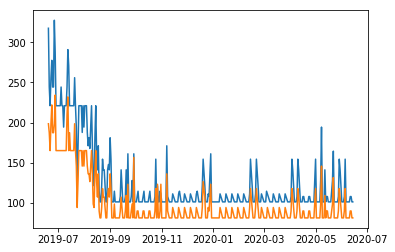

In [122]:
plt.plot_date(Data.loc[(Data['carrier']=='LG')&(Data['min_stay']=='one way')&(Data['origin']=='LUX')&(Data['destination']=='CPH'),'outbound_departure_date'],
Data.loc[(Data['carrier']=='LG')&(Data['min_stay']=='one way')&(Data['origin']=='LUX')&(Data['destination']=='CPH'),'price_exc'],'-')
plt.plot_date(Data.loc[(Data['carrier']=='SK')&(Data['min_stay']=='one way')&(Data['origin']=='LUX')&(Data['destination']=='CPH'),'outbound_departure_date'],
Data.loc[(Data['carrier']=='SK')&(Data['min_stay']=='one way')&(Data['origin']=='LUX')&(Data['destination']=='CPH'),'price_exc'],'-')

In [132]:
Data_lg['outbound_departure_time'].unique()

array(['08:35', '15:10', '20:30', '20:50', '15:50', '06:10', '12:40',
       '17:55', '13:20', '18:20', '18:00'], dtype=object)

In [69]:
Data_comp=Data_comp.groupby(['observation_date','origin','destination','outbound_departure_date','min_stay','carrier'])['price_exc_comp'].mean().reset_index()

In [70]:
Data=Data_lg.merge(Data_comp,on=['observation_date','origin','destination','outbound_departure_date','min_stay'],how='left')

In [71]:
Data

,observation_date,origin,destination,outbound_departure_date,min_stay,price_exc_lg,carrier,price_exc_comp
0,2019-06-18,CPH,LUX,2019-06-18,0 days,462.000000,KL,907.758333
1,2019-06-18,CPH,LUX,2019-06-18,2 days,378.666667,KL,746.980897
2,2019-06-18,CPH,LUX,2019-06-18,2 days,378.666667,SK,348.530000
3,2019-06-18,CPH,LUX,2019-06-18,one way,221.000000,KL,466.603333
4,2019-06-18,CPH,LUX,2019-06-18,one way,221.000000,SK,164.450000
5,2019-06-18,CPH,LUX,2019-06-19,0 days,347.000000,KL,639.341667
6,2019-06-18,CPH,LUX,2019-06-19,2 days,377.000000,KL,612.882564
7,2019-06-18,CPH,LUX,2019-06-19,2 days,377.000000,SK,409.888889
8,2019-06-18,CPH,LUX,2019-06-19,one way,254.333333,KL,378.069167
9,2019-06-18,CPH,LUX,2019-06-19,one way,254.333333,SK,239.446667


In [12]:
Data['price_diff']=Data['price_exc_lg']-Data['price_exc_comp']

In [13]:
Data['outbound_departure_date']=pd.to_datetime(Data['outbound_departure_date'])

In [14]:
Data.columns

Index(['observation_date', 'origin', 'destination', 'outbound_departure_date',
       'min_stay', 'price_exc_lg', 'carrier', 'price_exc_comp', 'price_diff'],
      dtype='object')

In [15]:
Data.loc[Data['outbound_departure_date']>=pd.to_datetime('2019-09-15'),:].groupby('carrier')['price_diff']\
.apply(lambda x: sum(x>0)/len(x))

carrier
KL    0.085324
SK    0.616858
Name: price_diff, dtype: float64

In [21]:
Data.loc[Data['outbound_departure_date']<=pd.to_datetime('2019-09-30'),:]

,observation_date,origin,destination,outbound_departure_date,min_stay,price_exc_lg,carrier,price_exc_comp,price_diff
0,2019-06-18,CPH,LUX,2019-06-18,-1,221.000000,KL,466.603333,-245.603333
1,2019-06-18,CPH,LUX,2019-06-18,-1,221.000000,SK,164.450000,56.550000
2,2019-06-18,CPH,LUX,2019-06-18,0,462.000000,KL,907.758333,-445.758333
3,2019-06-18,CPH,LUX,2019-06-18,2,378.666667,KL,746.980897,-368.314231
4,2019-06-18,CPH,LUX,2019-06-18,2,378.666667,SK,348.530000,30.136667
5,2019-06-18,CPH,LUX,2019-06-19,-1,254.333333,KL,378.069167,-123.735833
6,2019-06-18,CPH,LUX,2019-06-19,-1,254.333333,SK,239.446667,14.886667
7,2019-06-18,CPH,LUX,2019-06-19,0,347.000000,KL,639.341667,-292.341667
8,2019-06-18,CPH,LUX,2019-06-19,2,377.000000,KL,612.882564,-235.882564
9,2019-06-18,CPH,LUX,2019-06-19,2,377.000000,SK,409.888889,-32.888889


In [2]:
columns=['id', 'observation_date', 'observation_time', 'pos', 'origin',
       'destination', 'is_one_way', 'outbound_travel_stop_over',
       'inbound_travel_stop_over', 'carrier', 'outbound_flight_no',
       'inbound_flight_no', 'outbound_departure_date',
       'outbound_departure_time', 'outbound_arrival_date',
       'outbound_arrival_time', 'inbound_departure_date',
       'inbound_departure_time', 'inbound_arrival_date',
       'inbound_arrival_time', 'outbound_fare_basis', 'inbound_fare_basis',
       'outbound_booking_class', 'inbound_booking_class', 'price_exc',
       'price_inc', 'tax', 'currency', 'source', 'price_outbound',
       'price_inbound', 'is_tax_inc_outin', 'search_class',
       'outbound_fare_family', 'inbound_fare_family', 'outbound_seats',
       'inbound_seats', 'min_stay', 'outbound_flight_duration',
       'inbound_flight_duration']

In [3]:
Data=DataFrame(columns=columns)

In [4]:
files=sorted([x for x in os.listdir() if 'csv' in x])

In [5]:
for f in files:
    Intermediate=pd.read_csv(f)
    Data=pd.concat([Data,Intermediate])
Data.index=range(Data.shape[0])

/home/ubuntu/project-python/.venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
Data.loc[Data['origin']=='HAM',:]

,extraction_date,id,observation_date,observation_time,pos,origin,destination,is_one_way,outbound_travel_stop_over,inbound_travel_stop_over,...,price_inbound,is_tax_inc_outin,search_class,outbound_fare_family,inbound_fare_family,outbound_seats,inbound_seats,min_stay,outbound_flight_duration,inbound_flight_duration


In [14]:
sorted(Data['origin'].unique())

['BCN',
 'BGY',
 'BRI',
 'BRU',
 'CGN',
 'CPH',
 'CRL',
 'DUB',
 'HHN',
 'LCY',
 'LGG',
 'LGW',
 'LHR',
 'LIN',
 'LIS',
 'LUX',
 'MAD',
 'MRS',
 'MUC',
 'MXP',
 'NCE',
 'OPO',
 'SCN',
 'STN',
 'SXB',
 'SXF',
 'TSF',
 'TXL',
 'VCE',
 'VIE']

In [4]:
Data['outbound_departure_time']=Data['outbound_departure_time']+':00'
Data['outbound_departure_dt']=pd.to_datetime(Data['outbound_departure_date']+' '+Data['outbound_departure_time'])

Data['outbound_arrival_time']=Data['outbound_arrival_time']+':00'
Data['outbound_arrival_dt']=pd.to_datetime(Data['outbound_arrival_date']+' '+Data['outbound_arrival_time'])

Data['inbound_departure_time']=Data['inbound_departure_time']+':00'
Data['inbound_departure_dt']=pd.to_datetime(Data['inbound_departure_date']+' '+Data['inbound_departure_time'])

Data['inbound_arrival_time']=Data['inbound_arrival_time']+':00'
Data['inbound_arrival_dt']=pd.to_datetime(Data['inbound_arrival_date']+' '+Data['inbound_arrival_time'])

In [5]:
Data['outbound_departure_time']=Data['outbound_departure_time']+':00'
Data['outbound_departure_dt']=pd.to_datetime(Data['outbound_departure_date'],format='%Y-%m-%d')

Data['outbound_arrival_time']=Data['outbound_arrival_time']+':00'
Data['outbound_arrival_dt']=pd.to_datetime(Data['outbound_arrival_date'],format='%Y-%m-%d')

Data['inbound_departure_time']=Data['inbound_departure_time']+':00'
Data['inbound_departure_dt']=pd.to_datetime(Data['inbound_departure_date'],format='%Y-%m-%d')

Data['inbound_arrival_time']=Data['inbound_arrival_time']+':00'
Data['inbound_arrival_dt']=pd.to_datetime(Data['inbound_arrival_date'],format='%Y-%m-%d')

In [6]:
Data['DayDiff']=Data['inbound_departure_dt']-Data['outbound_departure_dt']

In [12]:
Data['carrier'].unique()

array(['LG', 'AZ', 'OS', 'U2', 'LH', 'KL', 'SK', 'FR', 'TP', 'BA', 'V7',
       'X3', 'EW', 'TB', 'SN'], dtype=object)

In [10]:
Data.loc[1,:]

id                                 1296037176340
observation_date                      2019-06-18
observation_time                           00:05
pos                                           DK
origin                                       CPH
destination                                  LUX
is_one_way                                     0
outbound_travel_stop_over                    NaN
inbound_travel_stop_over                     NaN
carrier                                       LG
outbound_flight_no                        LG5434
inbound_flight_no                         LG5437
outbound_departure_date               2019-09-09
outbound_departure_time              08:35:00:00
outbound_arrival_date                 2019-09-09
outbound_arrival_time                10:25:00:00
inbound_departure_date                2019-09-11
inbound_departure_time               12:40:00:00
inbound_arrival_date                  2019-09-11
inbound_arrival_time                 14:30:00:00
outbound_fare_basis 

In [198]:
#Data['DayDiff']=Data['DayDiff'].apply(lambda x: np.round(x.total_seconds()/(24*60*60)))
Data['DayDiff']=Data['DayDiff'].apply(lambda x: x.days)

In [199]:
test=Data.loc[Data['DayDiff']!=Data['min_stay'],['outbound_departure_date',
       'outbound_departure_time', 'outbound_arrival_date',
       'outbound_arrival_time', 'inbound_departure_date',
       'inbound_departure_time', 'inbound_arrival_date',
       'inbound_arrival_time','min_stay','DayDiff']]
test.index=range(test.shape[0])

In [200]:
test.loc[0,:]

outbound_departure_date     2019-06-24
outbound_departure_time    11:10:00:00
outbound_arrival_date       2019-06-24
outbound_arrival_time      12:40:00:00
inbound_departure_date             NaN
inbound_departure_time             NaN
inbound_arrival_date               NaN
inbound_arrival_time               NaN
min_stay                             0
DayDiff                            NaN
Name: 0, dtype: object

In [204]:
Data['outbound_departure_dt'].unique()

array(['2019-09-09T00:00:00.000000000', '2019-09-10T00:00:00.000000000',
       '2019-06-24T00:00:00.000000000', '2019-09-11T00:00:00.000000000',
       '2019-06-19T00:00:00.000000000', '2019-07-07T00:00:00.000000000',
       '2019-09-12T00:00:00.000000000', '2019-09-13T00:00:00.000000000',
       '2019-09-14T00:00:00.000000000', '2019-07-08T00:00:00.000000000',
       '2019-09-15T00:00:00.000000000', '2019-09-16T00:00:00.000000000',
       '2019-06-20T00:00:00.000000000', '2019-09-17T00:00:00.000000000',
       '2019-09-18T00:00:00.000000000', '2019-09-19T00:00:00.000000000',
       '2019-07-09T00:00:00.000000000', '2019-09-20T00:00:00.000000000',
       '2019-09-21T00:00:00.000000000', '2019-09-22T00:00:00.000000000',
       '2019-09-23T00:00:00.000000000', '2019-07-10T00:00:00.000000000',
       '2019-09-24T00:00:00.000000000', '2019-09-25T00:00:00.000000000',
       '2019-09-26T00:00:00.000000000', '2019-09-27T00:00:00.000000000',
       '2019-07-11T00:00:00.000000000', '2019-09-28

In [203]:
Data[[x for x in Data.columns if 'dt' in x]]

,outbound_departure_dt,outbound_arrival_dt,inbound_departure_dt,inbound_arrival_dt
0,2019-09-09,2019-09-09,2019-09-11,2019-09-11
1,2019-09-09,2019-09-09,2019-09-11,2019-09-11
2,2019-09-09,2019-09-09,2019-09-11,2019-09-11
3,2019-09-09,2019-09-09,2019-09-11,2019-09-11
4,2019-09-09,2019-09-09,2019-09-11,2019-09-11
5,2019-09-09,2019-09-09,2019-09-11,2019-09-11
6,2019-09-09,2019-09-09,2019-09-11,2019-09-11
7,2019-09-10,2019-09-10,2019-09-10,2019-09-10
8,2019-09-10,2019-09-10,2019-09-10,2019-09-10
9,2019-09-10,2019-09-10,2019-09-12,2019-09-12


In [18]:
Data['pos'].unique()

array(['DK', 'LU', 'PT', 'DE', 'IT', 'UK', 'AT', 'ES', 'FR'], dtype=object)

In [21]:
Data['carrier'].unique()

array(['KL', 'OS', 'LH', 'LG', 'AZ', 'SK', 'FR', 'U2', 'TP', 'BA', 'V7',
       'X3', 'EW'], dtype=object)